# Using several classifiers and tuning parameters - Parameters grid
[From official `scikit-learn` documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html)

Adapted by Claudio Sartori

Example of usage of the ***model selection*** features of `scikit-learn` and comparison of several classification methods.
1. import a sample dataset 
1. do the usual preliminary data explorations and separate the predicting attributes from the *target* `'Exited'`
1. define the _models_ that will be tested and prepare the _hyperparameter ranges_ for the modules
1. set the list of *score functions* to choose from
1. split the dataset into two parts: train and test
1. Loop on score functions and, for each score, loop on the model labels (see details below)
    - optimize with GridSearchCV
    - test
    - store the results of best model
1. for each scoring show the best models for each classifier, sorted by decreasing performance
1. for each scoring show the confusion matrix of the prediction given by the best model

In [1]:
"""
@author: scikit-learn.org and Emanuele Monsellato 
"""
import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

print(__doc__) # print information included in the triple quotes at the beginning


@author: scikit-learn.org and Emanuele Monsellato 



# 0. Initial settings
Set the random state and set the seed with `np.random.seed()`

Set the test set size and the number of cross valitadion splits

In [2]:
ts = 0.3 # test size
random_state = 42
np.random.seed(random_state) # this sets the random sequence. Setting only this the repeatability is guaranteed
                             # only if we re-execute the entire notebook
cv = 3   # number of cross-validation splits

# 1. Import the dataset

In [12]:
# Figure Size 
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams.update({'font.size': 16})

#Import DATASET 
data_url ="./churn-analysis.csv"
sep = ','
target = 'Exited'

df = pd.read_csv(data_url, sep=sep)
#df = df.dropna() # drop rows with missing values
#df = df.drop_duplicates() # drop duplicates rows
print("Shape of the imput data{}".format(df.shape))
df.head()

Shape of the imput data(5014, 10)


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,42,2,0.00,1,1,1,101348.88,True
1,502,0,42,8,159660.80,3,1,0,113931.57,True
2,699,0,39,1,0.00,2,0,0,93826.63,False
3,822,1,50,7,0.00,2,1,1,10062.80,False
4,501,1,44,4,142051.07,2,0,1,74940.50,False


# 2. Explore the data

The output of exploration is not shown here

In [18]:
print('The target variable is: {}'.format(target))
print('The target variable has {}'.format(df[target].nunique(),))
print('The target variable has the following unique values: {}'.format(df[target].unique()))
print('The target variable has the following distribution: \n{}'.format(df[target].value_counts()))

The target variable is: Exited
The target variable has 2
The target variable has the following unique values: [ True False]
The target variable has the following distribution: 
Exited
False    4204
True      810
Name: count, dtype: int64


Infp pf the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5014 entries, 0 to 5013
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      5014 non-null   int64  
 1   Gender           5014 non-null   int64  
 2   Age              5014 non-null   int64  
 3   Tenure           5014 non-null   int64  
 4   Balance          5014 non-null   float64
 5   NumOfProducts    5014 non-null   int64  
 6   HasCrCard        5014 non-null   int64  
 7   IsActiveMember   5014 non-null   int64  
 8   EstimatedSalary  5014 non-null   float64
 9   Exited           5014 non-null   bool   
dtypes: bool(1), float64(2), int64(7)
memory usage: 357.6 KB


Description of the dataset


Columns of the dataset Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')




<Figure size 1200x600 with 0 Axes>

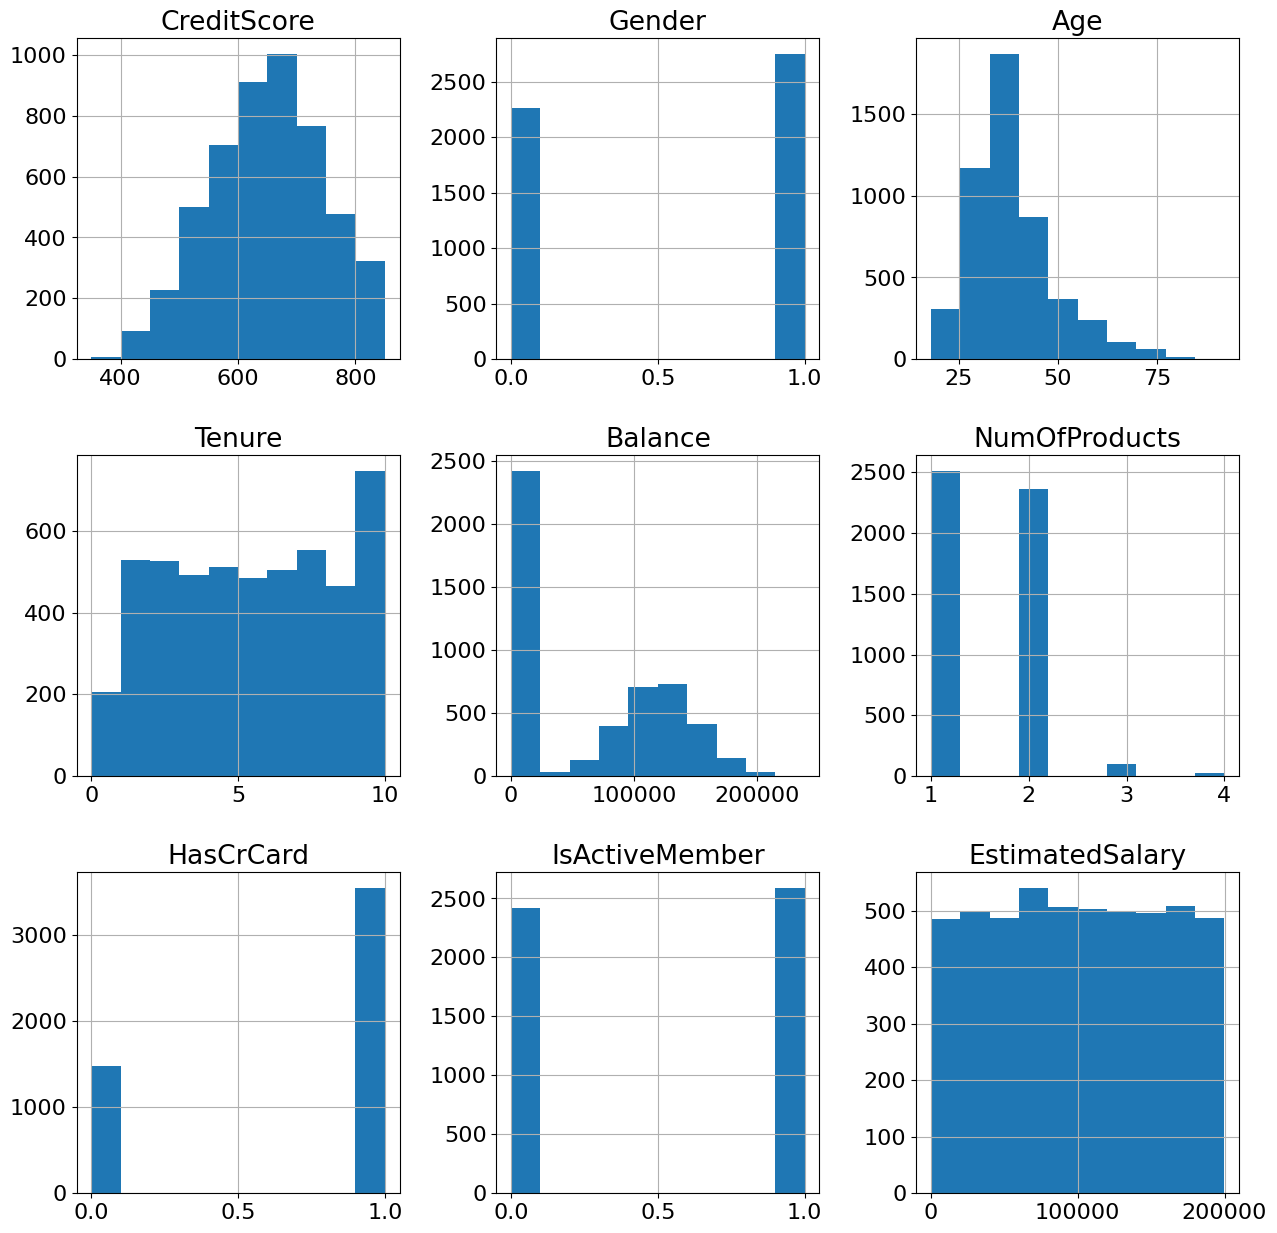

Features shape: (5014, 9)
Target shape: (5014,)


In [38]:
# display here some exploration output
print('Infp pf the dataset')
df.info()
print('\n')
print('Description of the dataset')
df.describe()
print('\n')
print('Columns of the dataset {}'.format(df.columns))
print('\n')

plt.figure(1)
pd.DataFrame.hist(df, figsize = [15,15]);

"""
plt.figure(2)
plt.hist(df['Age']);
plt.title('Age distribution');
"""
plt.show()

# Split the dataset in features and target variable
X = df.drop(target, axis=1) # Features
y = df[target] # Target variable
print('Features shape: {}'.format(X.shape))
print('Target shape: {}'.format(y.shape))


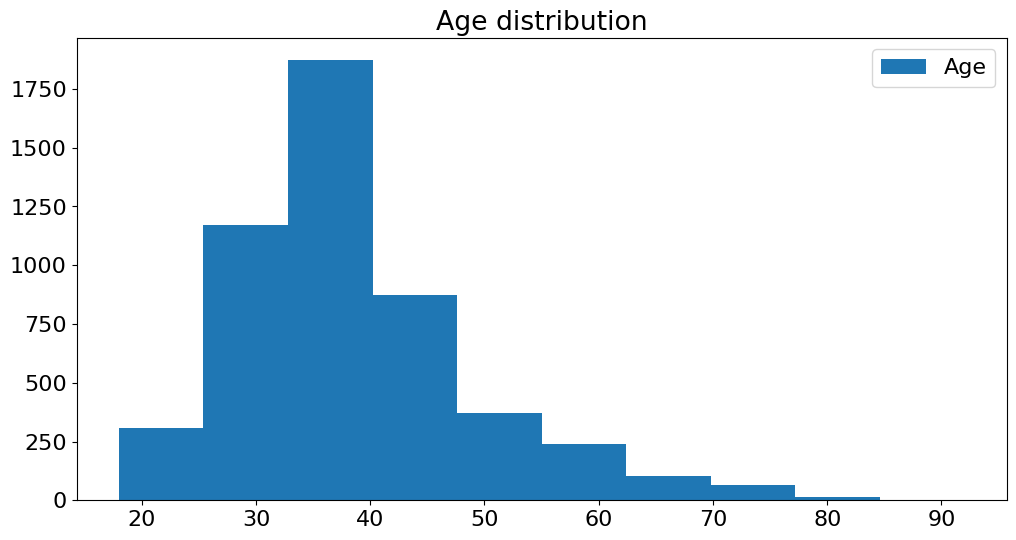

Age distribution


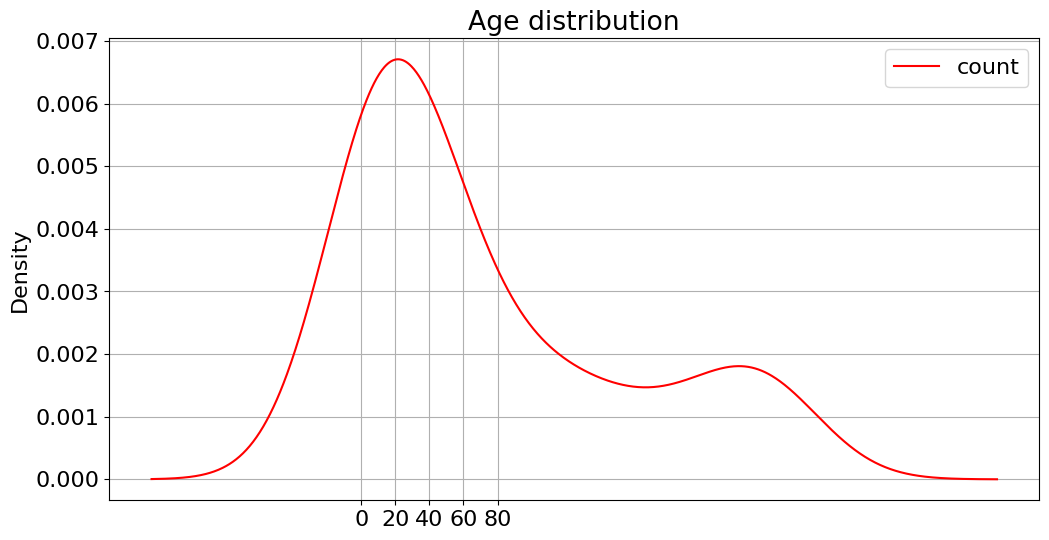

In [70]:
age ='Age'
plt.hist(df[age]);
plt.title('Age distribution');
plt.legend([age]);
plt.show()

print('Age distribution')
df[age].value_counts(sort=False).plot(kind='density', color='r', title='Age distribution', grid=True);
plt.xticks(np.arange(0, 100, step=20))
plt.legend()
plt.show()

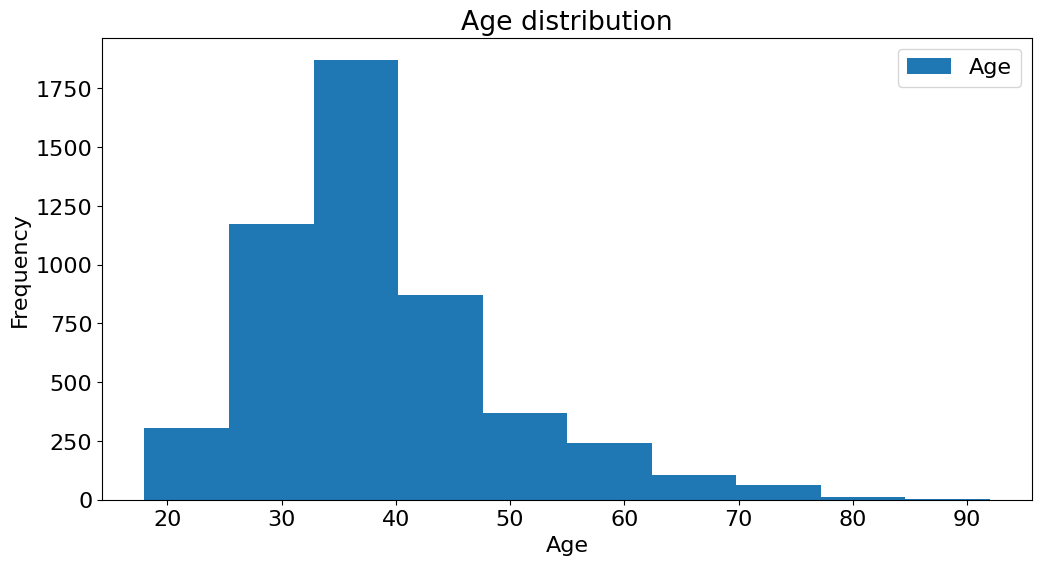

Age distribution


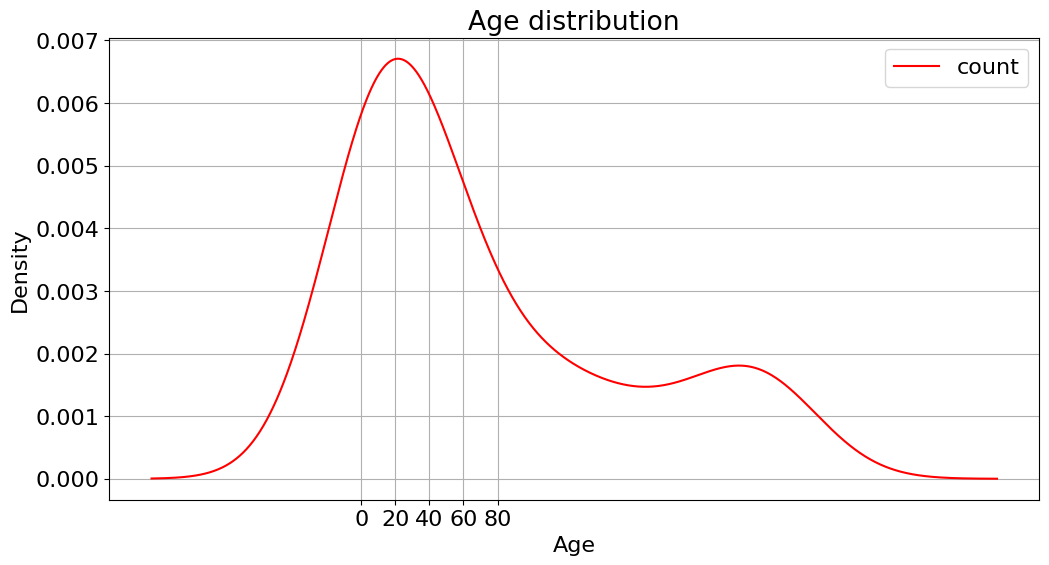

In [69]:
# With legend 

age = 'Age'

# Istogramma della distribuzione dell'età
plt.hist(df[age])
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend([age])
plt.show()

print('Age distribution')

# Densità della distribuzione dell'età
df[age].value_counts(sort=False).plot(kind='density', color='r', title='Age distribution', grid=True)
plt.xlabel('Age')
plt.ylabel('Density')
plt.xticks(np.arange(0, 100, step=20))
plt.legend()
plt.show()

# 3. Define the _models_ 
Prepare the _hyperparameter ranges_ for the modules

Put everything in a dictionary, for ease of use

Please read carefully these data structures and understand them

It is also useful to read the API documentation of each classifier, in order to understand the hyperparameters

In [7]:
model_lbls = ['dt' # decision tree
             ,'nb' # gaussian naive bayes
             ,'lp'   # linear perceptron
      #        ,'svc'  # support vector # deactivate if running time becomes too long
             ,'knn'  # k nearest neighbours
             ,'adb'  # adaboost
             ,'rf'   # random forest
            ]

models = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(random_state=random_state), 
           'param': [{'max_depth': [*range(1,20)],'class_weight':[None,'balanced']}],
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': [{'var_smoothing': [10**exp for exp in range(-3,-13,-1)]}]
          },
    'lp': {'name': 'Linear Perceptron   ',
           'estimator': Perceptron(random_state=random_state),
           'param': [{'early_stopping': [True,False],'class_weight':[None,'balanced']}],
          },
    'svc':{'name': 'Support Vector      ',
           'estimator': SVC(random_state=random_state), 
           'param': [{'kernel': ['rbf'], 
                    'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100],
                    },
                    {'kernel': ['linear'],
                     'C': [1, 10, 100],                     
             },
                   ]
          },
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': [{'n_neighbors': list(range(1,7))}]
       },
    'adb':{'name': 'AdaBoost           ',
           'estimator': AdaBoostClassifier(random_state=random_state),
           'param': [{'n_estimators':[10,20,30,40,50]
                     ,'learning_rate':[0.2,0.5,0.75,1,1.25,1.5]}]
          },
    'rf': {'name': 'Random forest       ',
           'estimator': RandomForestClassifier(random_state=random_state),
           'param': [{'max_depth': [*range(4,10)]
                     ,'n_estimators':[*range(10,60,10)]}]
          }

}

# 4. Set the list of *score functions* to choose from

# 5. Split the dataset into the train and test parts
    - the *train* part will be used for training and cross-validation (i.e. for *development*)
    - the *test* part will be used for test (i.e. for *evaluation*)
    - the fraction of test data will be _ts_ (a value of your choice between 0.2 and 0.5)

In [72]:
random_state = 17
train_size = 0.67

X_train, X_test, y_train, y_test = train_test_split(X, y
                                                    , train_size = train_size
                                                    , random_state = random_state) # default Train 0.75- Test 0.25
print("There are {} samples in the training dataset".format(X_train.shape[0]))
print("There are {} samples in the testing dataset".format(X_test.shape[0]))
print("Each sample has {} features".format(X_train.shape[1]))

There are 3359 samples in the training dataset
There are 1655 samples in the testing dataset
Each sample has 9 features


Training on 3509 examples


# 6. Loop on scores and, for each score, loop on the model labels

The function `GridSearchCV` iterates a cross validation experiment to train and test a model with different combinations of paramater values
- for each parameter we have set before a list of values to test, `ParametersGrid` will be implicitly called to generate all the combinations
- we choose a *score function* which will be used for the optimization
    - e.g. `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, see this [page](https://scikit-learn.org/stable/modules/model_evaluation.html) for reference
- the output is a dataframe containing 
    - the set of parameters maximising the score 
    - the score used for optimisation and all the test scores

### Steps

- prepare an empty list `clfs` to store all the fitte models
- prepare an empty DataFrame which will collect the results of the fittings with each combination of parameters
    - dataframe columns are `'scoring','model','best_params','accuracy','precision_macro','recall_macro','f1_macro'`
- loop

In [11]:
clfs = []
results = pd.DataFrame(columns=['scoring','model','best_params'#,'fit+score_time'
                                ,'accuracy','precision_macro','recall_macro','f1_macro'])

### Parameters to collect

`classification_report` produces a dictionary containing some classification performance measures, given the *ground truth* and the *predictions* (use the parameter `output_dict=True`)

The measures are (among others):
- `accuracy`
- `macro avg` a dictionary containing:
    - `precision`
    - `recall`
    - `f1-score`
- ...


### Loop

- repeat for all the chosen scorings
    - repeat for all the chosen classification models
        - store in `clf` the initialisation of `GridSearchCV` with the appropriate
            - classification model
            - parameters ranges
            - scoring
            - cross validation method `cv` (the same for all)
        - fit `clf` with the *train* part of `X` and `y`
        - store in `y_pred` the prediction for the *test* part of `X`
        - append `clf` to clfs`
        - append `y_pred` to `y_preds`
        - store in variable `cr` the `classification_report` produced with the test part of `y` and `y_pred`
        - store in the last row of `results` a list containing:
            - the name of the model
            - the `.best_params_` of `clf`
            - a selection of the contents of cr
                - 'accuracy', 
                - 'macro avg''precision'
                - 'macro avg''recall'
                - 'macro avg''f1-score'

Hints: 
- cr is a multi-level dictionary, second level can be reached 
with <br> `cr['first level label']['second level label']`
- to append a list as the last row of a dataframe you can use <br>
`df.loc[len(df)]=[]`

# 7. Display

For each scoring show the ranking of the models, and the confusion matrix given by the best model

For each scoring:
- set a `scoring_filter`
- filter the results of that scoring
- display the filtered dataframe with the `display()` function (it allows several displays of dataframes )



,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
4,AdaBoost,"{'learning_rate': 0.5, 'n_estimators': 30}",0.880,0.853,0.685,0.729
5,Random forest,"{'max_depth': 7, 'n_estimators': 30}",0.879,0.877,0.670,0.716
0,Decision Tree,"{'class_weight': None, 'max_depth': 4}",0.872,0.800,0.700,0.734
1,Gaussian Naive Bayes,{'var_smoothing': 1e-12},0.849,0.816,0.583,0.602
2,Linear Perceptron,"{'class_weight': None, 'early_stopping': True}",0.827,0.914,0.500,0.453
3,K Nearest Neighbor,{'n_neighbors': 6},0.821,0.525,0.502,0.465


,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
11,Random forest,"{'max_depth': 4, 'n_estimators': 20}",0.871,0.896,0.636,0.677
10,AdaBoost,"{'learning_rate': 0.2, 'n_estimators': 20}",0.842,0.882,0.545,0.540
7,Gaussian Naive Bayes,{'var_smoothing': 1e-12},0.849,0.816,0.583,0.602
6,Decision Tree,"{'class_weight': None, 'max_depth': 4}",0.872,0.800,0.700,0.734
8,Linear Perceptron,"{'class_weight': 'balanced', 'early_stopping': True}",0.175,0.587,0.501,0.150
9,K Nearest Neighbor,{'n_neighbors': 6},0.821,0.525,0.502,0.465


,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
12,Decision Tree,"{'class_weight': 'balanced', 'max_depth': 4}",0.724,0.649,0.744,0.651
16,AdaBoost,"{'learning_rate': 1.25, 'n_estimators': 10}",0.874,0.811,0.699,0.735
17,Random forest,"{'max_depth': 9, 'n_estimators': 20}",0.880,0.854,0.687,0.731
13,Gaussian Naive Bayes,{'var_smoothing': 1e-12},0.849,0.816,0.583,0.602
15,K Nearest Neighbor,{'n_neighbors': 1},0.728,0.524,0.524,0.524
14,Linear Perceptron,"{'class_weight': 'balanced', 'early_stopping': False}",0.260,0.504,0.503,0.259


,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
22,AdaBoost,"{'learning_rate': 1.25, 'n_estimators': 10}",0.874,0.811,0.699,0.735
18,Decision Tree,"{'class_weight': None, 'max_depth': 4}",0.872,0.800,0.700,0.734
23,Random forest,"{'max_depth': 9, 'n_estimators': 20}",0.880,0.854,0.687,0.731
19,Gaussian Naive Bayes,{'var_smoothing': 1e-12},0.849,0.816,0.583,0.602
21,K Nearest Neighbor,{'n_neighbors': 1},0.728,0.524,0.524,0.524
20,Linear Perceptron,"{'class_weight': 'balanced', 'early_stopping': False}",0.260,0.504,0.503,0.259


# 8. Confusion matrices

Use the `ConfusionMatrixDisplay` with the best model of each scoring to compare the predictions

Repeat for every scoring:
- filter the results for the current scoring
- find the row with the best value of the scoring 
- display the confusion matrix with an appropriate title

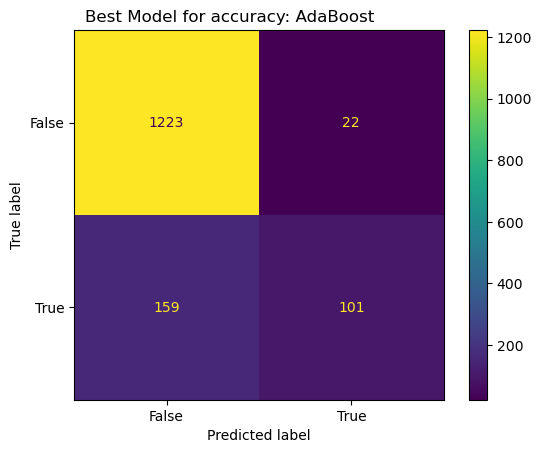

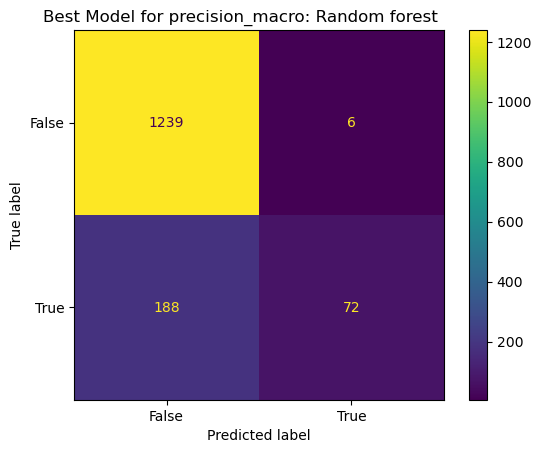

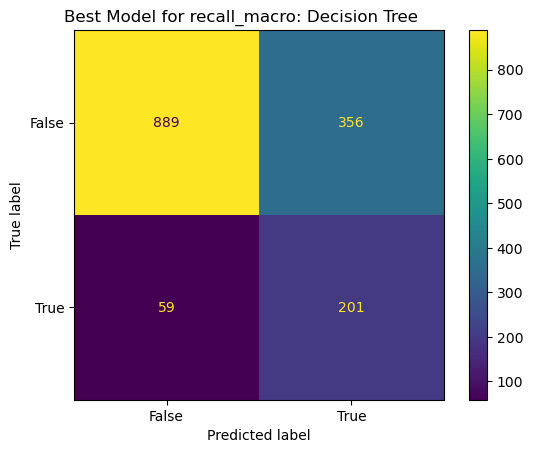

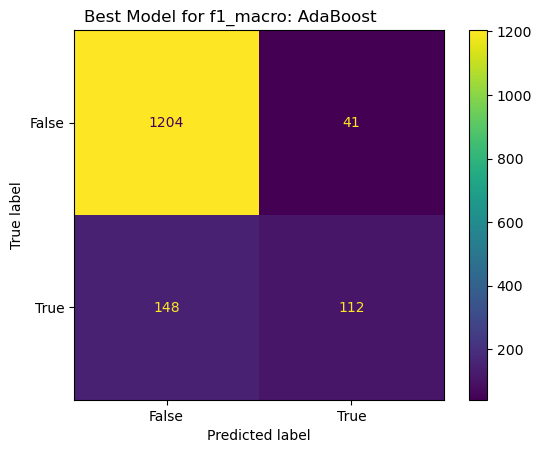